## Setup

In [0]:
!pip install tensorflow>=2.0 -Uq

In [0]:
import tensorflow

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import tensorflow.compat.v2 as tf

Helper functions for prettier displays

In [0]:
def plot_weights(array):
    """
    Plot attention weights
    """
    try:
        array = array.numpy()
    except:
        pass
    sns.heatmap(array[0,:].T)
    plt.title("Attention Map")
    plt.xlabel("Query")
    plt.ylabel("Key")
    plt.show()
    
def print_outputs(output):
    """
    Print value vector (V) or self-attention output
    """
    try:
        output = output.numpy()
    except:
        pass
    print("Output:")
    print(str(output[0]))

def causal_attention_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Exploring Self-Attention

In this notebook, we take a deep dive into the self-attention mechanism and see what it is doing.

We will explore an implementation of attention in TensorFlow 2.0 and some toy examples of self-attention.

![Self-attention mechanism](https://github.com/NVAITC/dnn_animations/raw/master/gif/self_attention.gif)

## Attention Mechanism

The attention mechanism takes in three vectors (query `Q`, key `K` and value `V`) and returns the product of `V` and an attention map.

We show a simple implementation of the **dot-product attention** mechanism as shown by the equation below. There are other methods of calculating attention scores, but dot-product is by far the most common method.

Note the optional the scaling of the dot-product by $\sqrt{H}$ (square-root of model dimension) in order to prevent the value of the dot-product from being too large. This is a problem for high dimensions.

$\text{attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{H}})V $

In addition to returning the output, we will also return the **attention map** so that we can visualize it and understand how attention works.

In [0]:
def attention(query, key, value, mask, scale=False):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    if scale:
        H = tf.cast(tf.shape(key)[-1], matmul_qk.dtype)
        matmul_qk = matmul_qk / tf.math.sqrt(H)
    # add the mask to zero out padding tokens
    mask = tf.cast(mask, matmul_qk.dtype)
    matmul_qk += (mask * -1e9)
    # softmax is normalized on the last axis (seq_len)
    attention_weights = tf.nn.softmax(matmul_qk, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

You may have noticed a `mask` in the implementation above.

Sometimes, it is not desirable to allow the attention mechanism to attend to all positions. Hence, we use can use an **attention mask** to prevent attention to specific positions. In positions where the mask has a value of `1`, the attention weight will be set to effectively zero.

## `K`, `Q` and `V` vectors

The **query** vector, `Q`, is a representation of the information that is relevant to the current token.

During the training process, the model learns to transform the input token into the `Q` vector via a fully-connected (dense) layer.

Below, we create a toy example of what the `Q` matrix might look like for a sequence of five tokens.

In [0]:
Q = tf.constant([[[0,10,0],
                  [0,10,0],
                  [0,10,0],
                  [10,0,0],
                  [0,0,10]]], dtype=tf.float32)

The **key** vector, `K`, is a representation of the type of information that is contained inside the current token. 

Same as the `Q` vector, this representation is learnt during the training process.

In [0]:
K = tf.constant([[[10,0,0],
                  [0,10,0],
                  [0,0,10],
                  [0,0,10],
                  [0,0,10]]], dtype=tf.float32)

In [8]:
print("K and Q have the same shape:", Q.shape)

K and Q have the same shape: (1, 5, 3)


The **value** vector, `V`, represents the semantic meaning encoded in the input token. 

Here, we are using a sequence of integer values to represent the input sequence.

The values reflect the indices of the individual elements (element 0 has value `0.0`).

We can use this as a proxy to identify which elements of the sequence are attended to later.

In [9]:
V = np.arange(int(K.shape[1]), dtype="float32").reshape((1,K.shape[1],1))

print("Sequence:", V.tolist())
print("Sequence length:", V.shape[1])
print("Sequence shape:", V.shape)

Sequence: [[[0.0], [1.0], [2.0], [3.0], [4.0]]]
Sequence length: 5
Sequence shape: (1, 5, 1)


## Performing Self-Attention

In [0]:
# causal attention mask - explained later
causal_mask = causal_attention_mask(K.shape[1])
# for now we will use no mask (no positions are masked)
no_mask = np.zeros_like(causal_mask)

In [11]:
output, attn_w = attention(Q, K, V, no_mask)

print("Output shape:", output.shape)
print("Attention Map shape:", attn_w.shape)

Output shape: (1, 5, 1)
Attention Map shape: (1, 5, 5)


The shape of `output` is same as the input `V`, while the attention map has shape `(seq_len, seq_len)`.

### Interpreting the Attention Map

We can visualize the attention map to inteprete what it is trying to do.

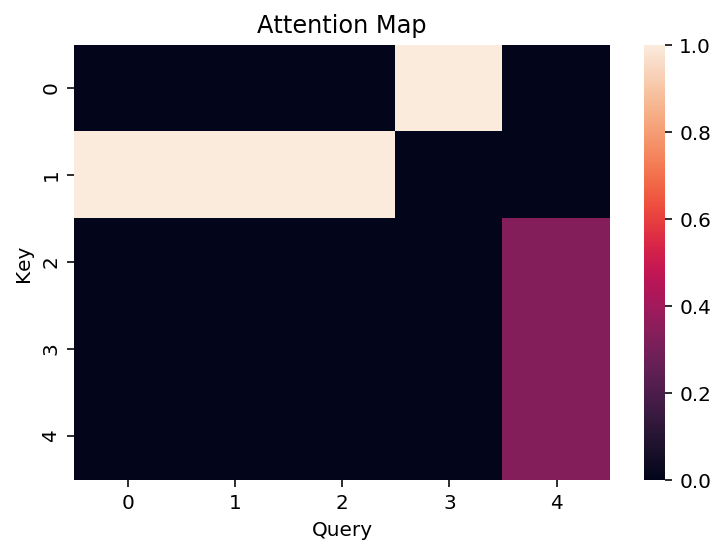

In [12]:
plot_weights(attn_w)

Moving horizontally across the map (x-axis), we see that positions `0`, `1` and `2` perform queries that attend to position `1`.

Looking at our `Q` vector, we see that the `Q` vector at positions `0`, `1`, `2` have the same value of `Q=[0,10,0]`. Comparing with all the possible key values in `K`, we find a direct match in index `1` (`K=[0,10,0]`).

Hence, we can see that the attention mechanism behaves conceptually similar to a dictionary lookup or database query, in that it searches for a key that matches the query. In the case of the attention mechanism, the "quality" of the match is given by the value of the dot product between `Q` and `V`, also referred to as the attention score. In our toy examples, all our `Q` and `K` vectors are large and octogonal to each other, resulting in either a very strong or a very weak match.

Likewise, we can see that:

* position `3` (`Q=[10,0,0]`) attends to position `0` (`K=[10,0,0]`)
* position `4` (`Q=[0,0,10]`) gives equal attention to positions `2`, `3` and `4` (`K=[0,0,10]`).

### Interpreting the Outputs

Here, we have the output from the attention mechanism: an array of five values.

In [13]:
print_outputs(output)

Output:
[[1.00e+00]
 [1.00e+00]
 [1.00e+00]
 [3.78e-43]
 [3.00e+00]]


Remember how our `V` vector contains a sequence of values from `0.0` to `4.0`?

The output of the self-attention operation shows that:

* Positions `0`, `1`, `2` retained information mostly from position `1`
* Position `3` retained information mostly from position `0`
* Position `4` retained information from a even mix of position `2`, `3`, `4`


## Causal Masking

Sometimes, we do not want the attention mechanism to be able to "look into the future". An example of this is in the decoder portion of a language model. At each position, we do not want to allow the attention mechanism to look into positions on the right ("future words"), but only attend to positions on the left ("past words").

In order to facilitate this, we introduce the concept of a **causal attention mask**.

In [14]:
causal_mask = causal_attention_mask(K.shape[1])

causal_mask

<tf.Tensor: id=25, shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

Now, we will use "softer" values for our `Q` and `K` vectors to get a more spread-out attention map.

This will allow us to see the masked-out areas of the map more easily.

In [0]:
Q = tf.constant([[[0.1,1.0,0.1],
                  [0.1,1.0,0.1],
                  [0.1,1.0,0.1],
                  [1.0,0.1,0.1],
                  [0.1,0.1,1.0]]], dtype=tf.float32)

K = tf.constant([[[1.0,0.1,0.1],
                  [0.1,1.0,0.1],
                  [0.1,0.1,1.0],
                  [0.1,0.1,1.0],
                  [0.1,0.1,1.0]]], dtype=tf.float32)

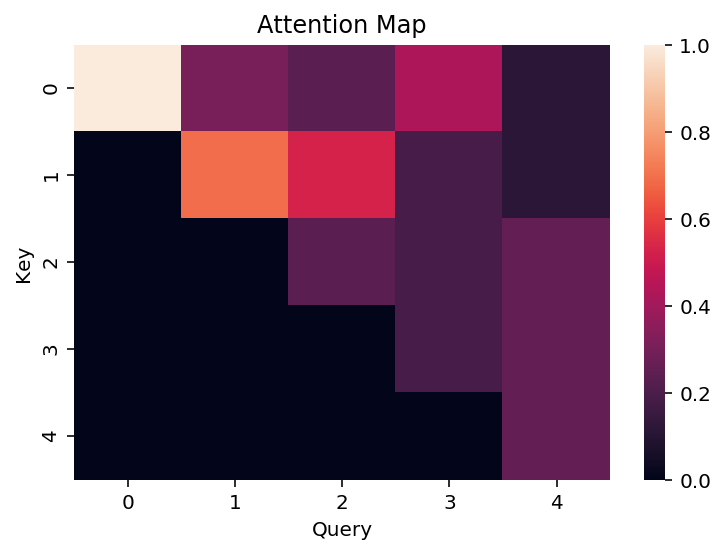

In [16]:
output, attn_w = attention(Q, K, V, causal_mask)
plot_weights(attn_w)

We observe that in the attention map, position `n` is not allowed to attend to keys at position `>n`. For example, position `2` cannot attend to position `3`. The effect of this can also be seen on the output:

In [17]:
print_outputs(output)

Output:
[[0.       ]
 [0.6921095]
 [1.       ]
 [1.1433128]
 [2.4281611]]


We can see that now, position `0` cannot attend to position `1` at all. However, position `1` and `2` are able to.

In the same way, position `4` can attend to all the other positions.